### Imported libraries
Google Maps API and Eventbrite API require keys to use.

In [212]:
import pandas as pd
from plotnine import *
import re

In [4]:
import googlemaps

from datetime import datetime
gmaps = googlemaps.Client(key='INSERT KEY HERE')

In [131]:
from eventbrite import Eventbrite
eventbrite = Eventbrite('INSERT KEY HERE')

### Xtern Housing and Coworking Locations

In [79]:
xternAddressDF = pd.read_csv('Data.xlsx - Sheet1.csv')
iupuiAddress = xternAddressDF['Address'][xternAddressDF['Name'] == 'IUPUI'][0]
display(xternAddressDF)

Name                                            Address  \
0                 IUPUI        415 Porto Alegre St, Indianapolis, IN 46202   
1        The Speak Easy     5255 Winthrop Ave #110, Indianapolis, IN 46220   
2                zWORKS          85 E Cedar St #1502, Zionsville, IN 46077   
3        Launch Fishers             12175 Visionary Way, Fishers, IN 46038   
4  Industrious Mass Ave  350 Massachusetts Ave Suite 300, Indianapolis,...   
5           Launch Indy          525 S Meridian St, Indianapolis, IN 46225   

        Type  
0    Housing  
1  Coworking  
2  Coworking  
3  Coworking  
4  Coworking  
5  Coworking

### The Speak Easy Data
The following code was used to gather a dataset for a single Coworking Location. The code was used to create more generic code which was used for gathering the combined dataset of all 5 coworking locations.

In [150]:
# The Speak Easy
speakEasyAddress = xternAddressDF['Address'][xternAddressDF['Name'] == 'The Speak Easy']
speakEasyQuery = gmaps.find_place(speakEasyAddress[1], 'textquery')
speakEasyID = speakEasyQuery['candidates'][0]['place_id']
speakEasy = gmaps.place(speakEasyID)['result']
speakEasyCoords = speakEasy['geometry']['location']
speakEasyNearby = gmaps.places_nearby(speakEasyCoords, 5000, type = 'restaurant')['results']
speakEasyRestaurantsDF = pd.DataFrame(speakEasyNearby)

speakEasyDistanceMatrix = gmaps.distance_matrix(speakEasyCoords, iupuiAddress, 'driving', units = 'imperial')
speakEasyDistance = speakEasyDistanceMatrix['rows'][0]['elements'][0]['distance']['text']
speakEasyRestaurantsDF['Coworking Space'] = 'The Speak Easy'
speakEasyRestaurantsDF['Distance to IUPUI'] = speakEasyDistance


### Restaurant Dataset
The following dataset has been compiled by locating the 20 closest restaurants to each Coworking Location. The restaurants for each location are combined into a single dataset and restaurants that are no longer open have been removed. Beyond the Google Maps API data, additional columns have been added to the dataset that include the Coworking Space from which the query for restaurants was made, the distance from the Coworking Space to IUPUI, and the distance to the restaurant from the Coworking Space.

In [245]:
locationDFs = []
count = 1
coworkingLocations = xternAddressDF['Name']
for address in xternAddressDF[1:6]['Address']:
    query = gmaps.find_place(address, 'textquery')
    coworkingID = query['candidates'][0]['place_id']
    location = gmaps.place(coworkingID)['result']
    coords = location['geometry']['location']
    nearby = gmaps.places_nearby(coords, type = 'restaurant', rank_by = 'distance')['results']
    df = pd.DataFrame(nearby)
    distanceMatrix = gmaps.distance_matrix(coords, iupuiAddress, 'driving', units = 'imperial')
    distance = distanceMatrix['rows'][0]['elements'][0]['distance']['text']
    df['Coworking Space'] = coworkingLocations[count]
    df['Distance to IUPUI'] = distance
    df['Distance to IUPUI'] = df['Distance to IUPUI'].str[:-3]
    df['Distance to IUPUI'] = df['Distance to IUPUI'].astype(float)
    coworkingSpaceDistance = []
    for restaurant in df['vicinity']:
        distance = gmaps.distance_matrix(coords, restaurant,'driving', units = 'imperial')['rows'][0]['elements'][0]['distance']['text']
        num = re.findall("\d+.?\d+", distance)[0]
        distanceFloat = float(num)
        if ('ft' in distance):
            distanceFloat = distanceFloat / 5280
        coworkingSpaceDistance.append(distanceFloat)
    df['Distance to Coworking Space'] = pd.Series(coworkingSpaceDistance)
    locationDFs.append(df)
    count = count + 1

restaurantDF = locationDFs[0]
for df in locationDFs[1:]:
    restaurantDF = restaurantDF.append(df)
restaurantDF = restaurantDF.drop('permanently_closed', axis = 1)
# include only operational restaurants
restaurantDF = restaurantDF[restaurantDF['business_status'] == 'OPERATIONAL']
# reset indices
restaurantDF = restaurantDF.reset_index()
restaurantDF = restaurantDF.drop('index', axis = 1)
restaurantDF = restaurantDF.reset_index()
display(restaurantDF)

index business_status                                           geometry  \
0       0     OPERATIONAL  {'location': {'lat': 39.8493489, 'lng': -86.14...   
1       1     OPERATIONAL  {'location': {'lat': 39.8507848, 'lng': -86.14...   
2       2     OPERATIONAL  {'location': {'lat': 39.85086, 'lng': -86.1408...   
3       3     OPERATIONAL  {'location': {'lat': 39.851468, 'lng': -86.139...   
4       4     OPERATIONAL  {'location': {'lat': 39.8513889, 'lng': -86.13...   
..    ...             ...                                                ...   
93     93     OPERATIONAL  {'location': {'lat': 39.7552108, 'lng': -86.15...   
94     94     OPERATIONAL  {'location': {'lat': 39.76341929999999, 'lng':...   
95     95     OPERATIONAL  {'location': {'lat': 39.7628795, 'lng': -86.15...   
96     96     OPERATIONAL  {'location': {'lat': 39.7549076, 'lng': -86.15...   
97     97     OPERATIONAL  {'location': {'lat': 39.7640113, 'lng': -86.15...   

                                                 icon icon_background_color  \
0   https://maps.gstatic.com/mapfiles/place_api/ic...               #FF9E67   
1   https://maps.gstatic.com/mapfiles/place_api/ic...               #FF9E67   
2   https://maps.gstatic.com/mapfiles/place_api/ic...               #FF9E67   
3   https://maps.gstatic.com/mapfiles/place_api/ic...               #FF9E67   
4   https://maps.gstatic.com/mapfiles/place_api/ic...               #FF9E67   
..                                                ...                   ...   
93  https://maps.gstatic.com/mapfiles/place_api/ic...               #FF9E67   
94  https://maps.gstatic.com/mapfiles/place_api/ic...               #FF9E67   
95  https://maps.gstatic.com/mapfiles/place_api/ic...               #FF9E67   
96  https://maps.gstatic.com/mapfiles/place_api/ic...               #FF9E67   
97  https://maps.gstatic.com/mapfiles/place_api/ic...               #FF9E67   

                                   icon_mask_base_uri  \
0   https://maps.gstatic.com/mapfiles/place_api/ic...   
1   https://maps.gstatic.com/mapfiles/place_api/ic...   
2   https://maps.gstatic.com/mapfiles/place_api/ic...   
3   https://maps.gstatic.com/mapfiles/place_api/ic...   
4   https://maps.gstatic.com/mapfiles/place_api/ic...   
..                                                ...   
93  https://maps.gstatic.com/mapfiles/place_api/ic...   
94  https://maps.gstatic.com/mapfiles/place_api/ic...   
95  https://maps.gstatic.com/mapfiles/place_api/ic...   
96  https://maps.gstatic.com/mapfiles/place_api/ic...   
97  https://maps.gstatic.com/mapfiles/place_api/ic...   

                                      name        opening_hours  \
0               Half Liter BBQ & Beer Hall   {'open_now': True}   
1                 Good Morning Mama's Cafe  {'open_now': False}   
2                           Mama Carolla's  {'open_now': False}   
3         Nicole-Taylor's Pasta and Market  {'open_now': False}   
4                                  Diavola  {'open_now': False}   
..                                     ...                  ...   
93                           Greek Islands  {'open_now': False}   
94  2021 Chicken & Beer Fest, Indianapolis                  NaN   
95                      QDOBA Mexican Eats   {'open_now': True}   
96            Ethiopian Eng’s Egg Workshop                  NaN   
97               The Old Spaghetti Factory  {'open_now': False}   

                                               photos  \
0   [{'height': 1932, 'html_attributions': ['<a hr...   
1   [{'height': 720, 'html_attributions': ['<a hre...   
2   [{'height': 3024, 'html_attributions': ['<a hr...   
3   [{'height': 476, 'html_attributions': ['<a hre...   
4   [{'height': 3648, 'html_attributions': ['<a hr...   
..                                                ...   
93  [{'height': 3024, 'html_attributions': ['<a hr...   
94  [{'height': 4032, 'html_attributions': ['<a hr...   
95  [{'height': 2340, 'html_attributions': ['<a hr...   
96                                

### Average Rating
The following bar graph gives the average rating to the closest restaurants for each Coworking Space.

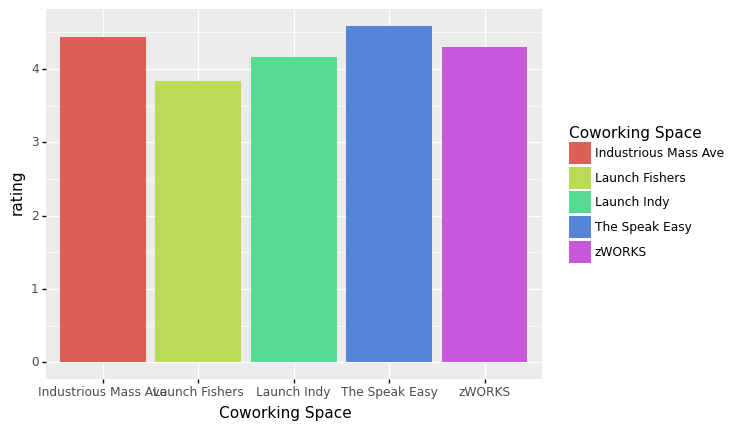

<ggplot: (100721648107)>

In [193]:
averageRating = restaurantDF.groupby('Coworking Space')['rating'].mean()
ratingDF = pd.DataFrame(averageRating).reset_index()
(ggplot(ratingDF, aes(x = 'Coworking Space', y = 'rating', fill = 'Coworking Space')) 
 + geom_col()
)

### Conclusion
The Speak easy has the highest average rating while Launch Fishers has noticeably lower ratings than the other Coworking Spaces with an average rating below 4. The other 4 Coworking Spaces all have an average rating above 4 which typically signifies a good restaurant.

### Distance to Coworking Space
This boxplot displays the distance from the closest restaurants to each coworking space.

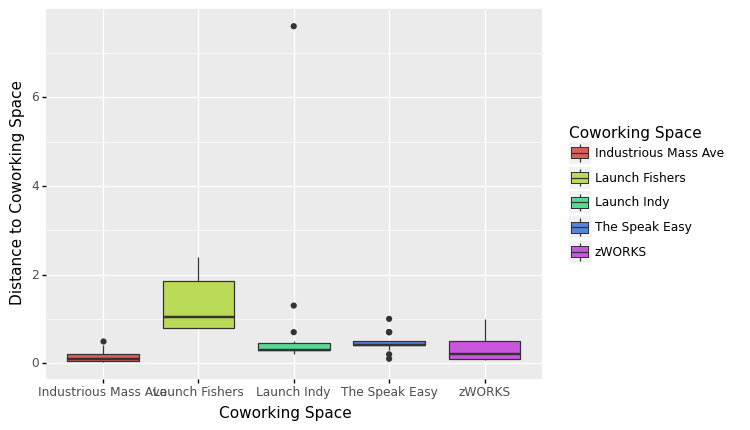

<ggplot: (100721801189)>

In [226]:
(ggplot(restaurantDF, aes(x = 'Coworking Space', y = 'Distance to Coworking Space', fill = 'Coworking Space'))
 + geom_boxplot()
)

### Conclusion
Once again, Launch Fisher is noticeable different than the other Coworking Locations. Its closest restaurants are signicantly further away from the Coworking Space than the other Coworking Spaces. All the other Coworking Spaces have similar mean distances that are all very close to the Coworking Space. Industrious Mass Ave has the closest distance, with almost all of its closest restaurants being within 0.5 miles of the Coworking Space.

### Distance to IUPUI
This bar graph displays the distance from each Coworking Space to IUPUI.

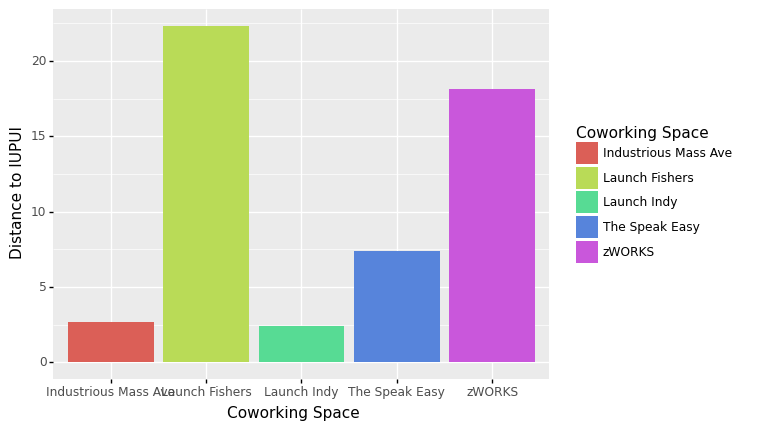

<ggplot: (100720481028)>

In [232]:
averageDistance = restaurantDF.groupby('Coworking Space')['Distance to IUPUI'].mean()
distanceDF = pd.DataFrame(averageDistance).reset_index()
(ggplot(ratingDF, aes(x = 'Coworking Space', y = 'Distance to IUPUI', fill = 'Coworking Space')) 
 + geom_col()
)

### Conclusion
Launch Fishers is the farthest Coworking Space from IUPUI with a distance of over 20 miles. zWorks is also significantly far away with a distance over 15 miles away. Industrious Mass and Launch Indy are both relatively close with distances less than 5 miles away and The Speak Easy is under 10 miles away. With Launch Fishers being the worst in the 3 qualities discussed so far, it is safe to remove Launch Fishers from contending as a viable Coworking Space.

### Restaurant Distance DataFrame
This DataFrame contains the latitude and longitude for each restaurant and the corresponding Coworking Space that it is closest to.

In [256]:
geometry = restaurantDF['geometry']
locationList = []
for dictionary in geometry:
    locationList.append(dictionary['location'])
distanceDF = pd.DataFrame(locationList)

distanceDF['Coworking Space'] = restaurantDF['Coworking Space']
display(distanceDF)

lat        lng Coworking Space
0   39.849349 -86.141442  The Speak Easy
1   39.850785 -86.141332  The Speak Easy
2   39.850860 -86.140849  The Speak Easy
3   39.851468 -86.139327  The Speak Easy
4   39.851389 -86.138889  The Speak Easy
..        ...        ...             ...
93  39.755211 -86.159498     Launch Indy
94  39.763419 -86.160331     Launch Indy
95  39.762879 -86.154320     Launch Indy
96  39.754908 -86.156719     Launch Indy
97  39.764011 -86.158417     Launch Indy

[98 rows x 3 columns]

### Scatterplot of Restaurant Distance
The scatterplot below graphs the longitude and latitude of each restaurant in the dataset. The points are distinguished by color associated to the Coworking Space that the restaurant is closest to.

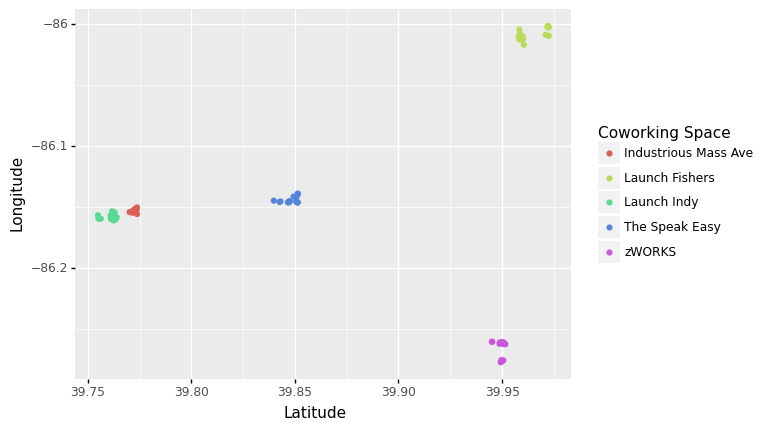

<ggplot: (100721982708)>

In [259]:
(ggplot(distanceDF, aes(x = 'lat', y = 'lng', color = 'Coworking Space'))
 + geom_point()
 + ylab('Longitude')
 + xlab('Latitude')
)

### Conclusion
The scatterplot shows how close the closest restaurants for each Coworking Space are to each other. Industrious Mass Ave can be clearly distinguished from the other Coworking Spaces as all of its restaurants are extremely close to each other and well-clustered while all of the other locations show some spread. All of the Coworking Spaces have restaurants that are all relatively close to each other, but Launch Fishers has restaurants that are the most spread out with 2 clear clusters of restaurants. zWorks and Launch Indy also have 2 distinct clusters of restaurants and The Speak Easy has restaurants that are more randomly scattered. 

# Final Conclusion
From the datasets, I conclude that Industrious Mass Ave is the best Coworking Space relative to the restaurants that surround it and its location relative to IUPUI. In every category, Industrious Mass Ave ranks highly. It appears to be a great location with many high rated restaurants in close proximity to the Coworking Space and a short commuting distance from the housing at IUPUI. Additionally, I would recommend avoiding Launch Fishers due to the wide spread of restaurants that are further from the Coworking Space and its significant distance away from IUPUI.

# Sample Activities Plan
## Week 1: May 15 - May 21
- [Puzzling Adventures Scavenger Hunt](https://www.eventbrite.com/e/one-team-scavenger-hunt-indianapolis-tickets-110667096264?aff=ebdssbdestsearch)
- May 21

### Week 2 : May 22 - May 28
- [THE LUME Indianapolis](https://www.visitindy.com/indianapolis-the-lume-indianapolis)
- May 28

### Week 3: May 29 - June 4
- [Indy 500 INDYCar Race](https://www.visitindy.com/indianapolis-500-mile-race)
- May 29

### Week 4: June 5 - June 11
- [Indianapolis Zoo: Tembo Camp](https://www.visitindy.com/indianapolis-tembo-camp-a-new-elephant-experience)
- June 5
- [Antony and Cleopatra Performance](https://www.visitindy.com/indianapolis-antony-and-cleopatra)
- June 11

### Week 5: June 12 - June 18
- [Talbot Street Art Fair](https://www.visitindy.com/indianapolis-talbot-street-art-fair)
- June 18

### Week 6: June 19 - June 25
- [The Basement in 30 Tour at Indianapolis Motor Speedway](https://www.visitindy.com/indianapolis-the-basement-in-30-tour)
- June 25

### Week 7: June 26 - July 2
- [Tedeschi Trucks Band- Wheels of Soul](https://www.visitindy.com/indianapolis-tedeschi-072820)
- June 28

### Week 8: July 3 - July 9
- [Eiteljorg Museum](https://eiteljorg.org/)
- July 9

### Week 9: July 10 - July 16
- [ComedySportz](https://www.downtownindy.org/events/9673/comedysportz/)
- July 15

### Week 10: July 17 - July 23
- [Trivia and Music Bingo](https://www.downtownindy.org/events/10841/trivia-and-music-bingo/)
- July 21


### Note
I had difficulties using the Eventbrite API as the API can no longer be used to search for events as of 2019.